In [1]:
print('Loading modules....')

import os, sys


import uproot
import numpy as np
import matplotlib.pyplot as plt
from qetpy.utils import lowpassfilter 
from qetpy import autocuts
import cdms
#from CDMSDataCatalog import CDMSDataCatalog
import scipy.optimize as optimize
import matplotlib as mpl
import pickle as pkl
import ROOT as rt
import seaborn as sns
import operator as op
import pandas as pd
from collections import Counter

print('modules loaded...')

Loading modules....


/cvmfs/cdms.opensciencegrid.org/releases/centos7/V04-00/lib/python3.7/site-packages/datacat/model.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import OrderedDict, MutableMapping


Welcome to JupyROOT 6.22/00
modules loaded...


In [2]:
series = ['23231219_184002']
event_numbers = [42499, 110523, 200199, 203569, 203576, 263548, 322159, 333501, 340031, 340043] #for Z1
#event_numbers = [42778, 60675, 61585, 102412, 111229, 150793, 152887, 190538, 193667, 221976] #for Z3
det = 'Z1'
detNum = int(det[-1])

## Load RQ related quantities

In [3]:
base = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2./Submerged'
file_prefix = 'CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2.'
# if(dataset == 'prompt'):
#     base = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Prompt/Prompt_V04-15_P0.2.1/Submerged'
#     file_prefix = 'Prompt_V04-15_P0.2.1'


filePath = []
found_series = []
for ser in series:
    
    fp = '%s/%s_%s.root'%(base,file_prefix,ser)
    if(os.path.exists(fp)):
        print(ser,' : ',fp)
        filePath.append(fp)
        found_series.append(ser)
    else:
        print('not found: ',fp)
series = found_series
print('Found series = ',series)


print('Loading RQ and Event Tree...')
RQ=[]
for i,ser in enumerate(series):
    RQ.append(uproot.open(filePath[i])['rqDir/zip%d'%(detNum)]) 

eventTree=[]
for i,ser in enumerate(series):
    eventTree.append(uproot.open(filePath[i])['rqDir/eventTree']) 

print('done..')


print('Loading OF spefic data....')
#Load RQs from processed files
channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']

OFchiq={}
OFamps={}
OFdelay={}
OFamps0={}
OFnorms={}
OFbs={}

for i,key in enumerate(series):
    tc={}
    ta={}
    td={}
    ta0={}
    tn = {}
    tbs = {}
    for c in channels:
        if(detNum == '3' and c == 'PAS1'):
            print('\tSkipping Z3-PAS1...')
            continue
        tc[c]=(RQ[i].array(c+"OFchisq"))
        ta[c]=(RQ[i].array(c+"OFamps"))
        ta0[c]=(RQ[i].array(c+"OFamps0"))
        td[c]=(RQ[i].array(c+"OFdelay"))
        if(c!='PT'):
            tn[c] = (RQ[i].array(c+"norm"))
            tbs[c] = (RQ[i].array(c+"bs"))
    OFchiq[key]=tc
    OFamps[key]=ta
    OFamps0[key]=ta0
    OFdelay[key]=td
    OFnorms[key]=tn
    OFbs[key]=tbs
    print('%s loaded'%(key))
    
print('done!')

print(' Loading Event specific data....')


TriggerTime=[]
TriggerType=[]
EventNumber=[]
TrigDet=[]
TriggerMask=[]
EventTime=[]

R2 = {} # Radial parameter for S2
R1 = {} # Radial parameter for S1
amp_diff = {}  
amp_diff_abs = {}
for i,key in enumerate(series):
    TriggerTime.append(eventTree[i].array("TriggerTime"))
    TriggerType.append(eventTree[i].array("TriggerType"))
    EventNumber.append(eventTree[i].array("EventNumber"))
    TrigDet.append(eventTree[i].array("TriggerDetectorNum"))
    TriggerMask.append(eventTree[i].array("TriggerMask"))
    EventTime.append(eventTree[i].array("EventTime"))
    R2[key] = OFdelay[key]['PFS2'] - OFdelay[key]['PAS2']
    R1[key] = OFdelay[key]['PFS1'] - OFdelay[key]['PAS1']
    amp_diff[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])/(OFamps[key]['PFS2'] + OFamps[key]['PAS2'])
    amp_diff_abs[key] = (OFamps[key]['PFS2'] - OFamps[key]['PAS2'])
    print('%s loaded'%(key))

print('Done!')

23231219_184002  :  /sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2./Submerged/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2._23231219_184002.root
Found series =  ['23231219_184002']
Loading RQ and Event Tree...
done..
Loading OF spefic data....
23231219_184002 loaded
done!
 Loading Event specific data....
23231219_184002 loaded
Done!


In [4]:
'''
    Load  OFamps, baseline, and delay for specific events
'''

proc_of = {}
proc_bs = {}
proc_delay = {}

for idx, key in enumerate(series):
    t_of = []
    t_bs = []
    t_delay = []
    for enum in event_numbers:
        tt_of = {}
        tt_bs = {}
        tt_delay = {}
        for c in channels:
            if(c != 'PT'):
                tt_bs[c] = ((OFbs[key][c][EventNumber[idx] == enum]))
            tt_of[c] = ((OFamps[key][c][EventNumber[idx] == enum]))
            
            tt_delay[c] = ((OFdelay[key][c][EventNumber[idx] == enum]))
        t_of.append(tt_of)
        t_bs.append(tt_bs)
        t_delay.append(tt_delay)
    proc_of[key] = t_of
    proc_bs[key] = t_bs
    proc_delay[key] = t_delay
print('done')

done


## Load Noise file to get templates

In [5]:
'''
    Get noise info from BatNoise file
'''
zips = {
    'Z1' : 'zip1',
    'Z2' : 'zip2',
    'Z3' : 'zip3',
    'Z4' : 'zip4',
    'Z5' : 'zip5',
    'Z6' : 'zip6'
}

noisebase = '/sdf/group/supercdms/data/CDMS/CUTE/R37/Processed/Tests/CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2./Noise'
noisefile_prefix = 'CUTE_T3_GeActivation_v1.0.0_V05-00_P0.2._Filter'


noisefile = []
for i,key in enumerate(series):
    path = '%s/%s_%s.root'%(noisebase,noisefile_prefix,key)
    file = rt.TFile.Open(path)
    if(not file):
        print('Couldnt open %s'%(path))
    noisefile.append(file)    

print('Files loaded...')

template_hist = {}
for i, key in enumerate(series):
    th = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        temp = noisefile[i].Get('%s/%sTemplateTime'%(zips[det],c))
        if(not temp):
            print('NULL for %s : %s'%(key,c))
        th[c] = temp
    template_hist[key] = th
print('Templates laoded as histograms...')

template = {}
for i, key in enumerate(series):
    tarr = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        bincenter = []
        bincontent = []
        #bincontent = [temp.GetBinContent(j) for j in temp.GetNbinsX()]
        temp = template_hist[key][c]
        for j in range(temp.GetNbinsX()):
            bincenter.append(temp.GetBinCenter(j))
            bincontent.append(temp.GetBinContent(j))
        tarr[c] = bincontent
    template[key] = tarr

print('Templates loaded as dict...')

Files loaded...
Templates laoded as histograms...
Templates loaded as dict...


## Load raw traces
* Change the values in the cell below accroding to the detector (UMN detectors have different settings)

In [6]:
Rshunt = 5.0e-3 # shunt resistance
Rfb = 5000.0 # feedback resistance
ADCperVolt = 65536.0/8.0 # the number of ADC bins per V for the readout
LoopRatio = 2.4 # SQUID turn ratio 
low_pass_filter = False
high_cutoff, fs, order = 100000, 625000, 2
trace_length = 1.6 # uS
bins = 32768
rawfilepath='/sdf/group/supercdms/data/CDMS/CUTE/R37/Raw/'

channels=['PT','PAS1','PBS1','PCS1','PDS1','PES1','PFS1','PAS2','PBS2','PCS2','PDS2','PES2','PFS2']


In [7]:
#Load detector settings
dsettings={}
for idx,key in enumerate(series):
    dsettings[key]=cdms.rawio.IO.getDetectorSettings(rawfilepath,key)

The file is: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23231219_184002/23231219_184002_F0001.mid.gz

Opened raw midas file: /sdf/group/supercdms/data/CDMS/CUTE/R37/Raw//23231219_184002/23231219_184002_F0001.mid.gz
INFO in DetectorConfigData: list of available detectors = 1, 2, 3, 4, 5, 6


### Make sure to create a `rawdata` directory. The pulses will be dumped to this directory in pickle format so that you don't have to load the data from midas file again and again which takes time.

In [8]:

data = {}
raw_data = {}
for idx, key in enumerate(series):
    c = 'PT'
    t_rd = {}
    
    for c in channels:
        fname = './rawdata/%s_%s_%s_1kev.pkl'%(key,det,c)
        if(c=='PT'):
            continue
        #event_number[c] = EventNumber[idx][cut][:10]
        if(det == 'Z3' and c == 'PAS1'):
            continue
        if os.path.exists(fname):
            t_rd[c] = pkl.load(open(fname, "rb"))
            print('pkl file loaded for %s'%(c))
        else:
            print('No pickle file available. Loading traces... ')
            
            t_rd[c] = cdms.rawio.IO.getRawEvents(rawfilepath,'/'+key,outputFormat = 2, eventNumbers=event_numbers, 
                                                   channelList=[c], detectorList=[detNum])
            pkl.dump(t_rd[c], open(fname, "wb"))
            
            print('pkl file loaded for %s'%(c))
    raw_data[key] = t_rd
    print('Raw traces [ADC] loaded...')
    



pkl file loaded for PAS1
pkl file loaded for PBS1
pkl file loaded for PCS1


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PAS1_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PBS1_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PCS1_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PDS1_1kev.pkl'>
  app.launch_new_instanc

pkl file loaded for PDS1
pkl file loaded for PES1
pkl file loaded for PFS1
pkl file loaded for PAS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PBS2_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PCS2_1kev.pkl'>
  app.launch_new_instance()


pkl file loaded for PBS2
pkl file loaded for PCS2


/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PDS2_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PES2_1kev.pkl'>
  app.launch_new_instance()
/cvmfs/sft.cern.ch/lcg/views/LCG_98py3cu10/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/ipykernel_launcher.py:16: ResourceWarning: unclosed file <_io.BufferedReader name='./rawdata/23231219_184002_Z1_PFS2_1kev.pkl'>
  app.launch_new_instance()


pkl file loaded for PDS2
pkl file loaded for PES2
pkl file loaded for PFS2
Raw traces [ADC] loaded...


In [9]:
'''
    Convert traces from ADC to uA
'''

data = {}
detNum = int(det[-1])
adc2ua = {}
for idx, key in enumerate(series):
    print('Now converting into amps...')
    t_adc2uA = {}
    t_d = {}
    t_rd = raw_data[key]
    for c in channels:
        if(c=='PT'):
            continue
        if(det == 'Z3' and c == 'PAS1'):
            continue
        temp = []
        DriverGain = dsettings[key][det][c]['driverGain']*4.0 #Apply Driver Gain Correction
        conv2Amps = 1/(Rfb*DriverGain*LoopRatio*ADCperVolt) #Convert detector parameters to amplitude for trace
        t_adc2uA[c] = conv2Amps
        
        for i in range(len(t_rd[c])):
            temp.append(((t_rd[c][i])[det][c])*conv2Amps)
        t_d[c] = temp
    data[key] = t_d
    adc2ua[key] = t_adc2uA
    
    print('-------- %s : Traces coverted to Amps for channel -------------'%(key))
print('all done')

Now converting into amps...
-------- 23231219_184002 : Traces coverted to Amps for channel -------------
all done


In [10]:

'''
  Compute pedestal subtracted traces
'''

traces_ped_sub = {}
for idx, key in enumerate(series):
    t = {}
    for c in channels:
        if(c == 'PT'):
            continue
        if(det=='Z3' and c == 'PAS1'):
            continue
        tt = []
        for i in range(len(event_numbers)):
            pedestal = proc_bs[key][i][c][0] * adc2ua[key][c]
            #ttt = data[key][c][i] - pedestal
            tt.append(data[key][c][i] - pedestal)
        t[c] = tt
    traces_ped_sub[key] = t
print('Done')

Done


In [11]:
'''
    Construct PT traces
'''


for idx, key in enumerate(series):
    
    tt = []
    for i in range(len(event_numbers)):
        t = np.zeros(bins)
        for c in channels:
            if(c == 'PT'):
                continue
            if(det=='Z3' and c=='PAS1'):
                continue
            t += traces_ped_sub[key][c][i]
        tt.append(t)
    
    traces_ped_sub[key]['PT'] = tt
print('Done')

Done


In [12]:
'''
    compute template for each event, each channel : time-shifted, scaled by ofamp
'''

template_ss = {} # per series , per channel, per event
for idx, key in enumerate(series):
    t = {}
    for c in channels:
        if(det=='Z3' and c=='PAS1'):
            continue
        tt = []
        for i in range(len(event_numbers)):
            shift = int((proc_delay[key][i][c]*1e6)/trace_length)
            scale = proc_of[key][i][c]
            ttt = np.array(template[key][c])
            ttt = np.roll(ttt,shift)
            ttt *= scale
            tt.append(ttt)
        t[c] = tt
    template_ss[key] = t

print('done!')

done!


In [13]:
'''
    Low pass filter
'''

import scipy.optimize as optimize
from scipy.signal import firwin, lfilter
def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
    # Calculate the Nyquist frequency
    nyquist_frequency = 0.5 * sampling_rate

    # Normalize the cutoff frequency
    normalized_cutoff = cutoff_frequency / nyquist_frequency

    # Design a low-pass FIR filter
    filter_coefficients = firwin(filter_order, normalized_cutoff, window='hamming')

    # Apply the filter to the signal using lfilter
    filtered_signal = lfilter(filter_coefficients, 1.0, signal)

    return filtered_signal


In [14]:
'''
    Cosmetics
'''

color_p = {
    'PAS1' : 'red',
    'PBS1' : 'orange',
    'PCS1' : 'brown',
    'PDS1' : 'blue',
    'PES1' : 'cyan',
    'PFS1' : 'green',
    'PAS2' : 'red',
    'PBS2' : 'orange',
    'PCS2' : 'brown',
    'PDS2' : 'blue',
    'PES2' : 'cyan',
    'PFS2' : 'green',
    'PT'   : 'black'
    
}
style_p = {
    'PAS1' : '-',
    'PBS1' : '-',
    'PCS1' : '-',
    'PDS1' : '-',
    'PES1' : '-',
    'PFS1' : '-',
    'PAS2' : '--',
    'PBS2' : '--',
    'PCS2' : '--',
    'PDS2' : '--',
    'PES2' : '--',
    'PFS2' : '--',
    'PT'   : '-'
}
# cycler = plt.cycler(linestyle=['-', '-', '-', '-', '-', '-', '--','--','--','--','--','--'],
#                     color=['maroon', 'orange', 'yellow', 'black', 'blue', 'green', 'maroon', 'orange', 'yellow', 'black', 'blue', 'green'],
# )

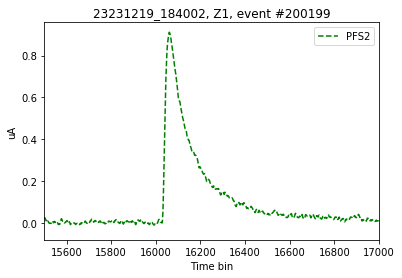

In [18]:

idx = 2
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
#     if(c=='PT'):
#         continue
    if(c!='PFS2'):
         continue

    if(det == 'Z3' and c == 'PAS1'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    #lp_filtered = (bs_corrected)
    
    plt.plot((lp_filtered)*1e6,label=c,color=color_p[c],linestyle=style_p[c])
    plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))
plt.legend()
plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
plt.xlabel('Time bin')
#plt.ylim(-0.02,0.14)
plt.show()

9.114887841901639e-07


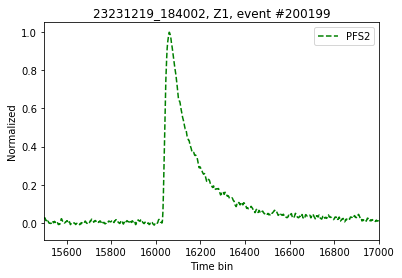

In [23]:

idx = 2
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
#     if(c=='PT'):
#         continue
    if(c!='PFS2'):
         continue

    if(det == 'Z3' and c == 'PAS1'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    #lp_filtered = (bs_corrected)
    print(max(lp_filtered))
    lp_filtered = lp_filtered/max(lp_filtered)
    plt.plot((lp_filtered),label=c,color=color_p[c],linestyle=style_p[c])
    plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))
plt.legend()
plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('Normalized')
plt.xlabel('Time bin')
#plt.ylim(-0.02,0.14)
plt.show()

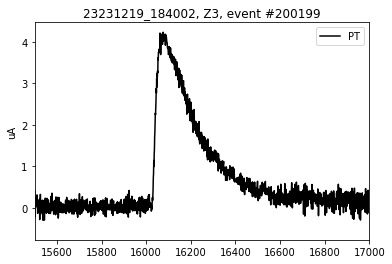

In [117]:

idx = 2
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
#def low_pass_filter(signal, cutoff_frequency, sampling_rate, filter_order=100):
for c in channels:
    if(c!='PT'):
        continue
   
#     trace = data[key][c][idx]
#     bs_corrected = trace - np.mean(trace[0:10000])
    bs_corrected = traces_ped_sub[key][c][idx]
    #lp_filtered = low_pass_filter(bs_corrected,high_cutoff,fs,order)
    lp_filtered = (bs_corrected)
    
    plt.plot((lp_filtered)*1e6,label=c,color=color_p[c],linestyle=style_p[c])
    plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))
plt.legend()
plt.xlim(15500,17000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
#plt.ylim(-0.02,0.14)
plt.show()

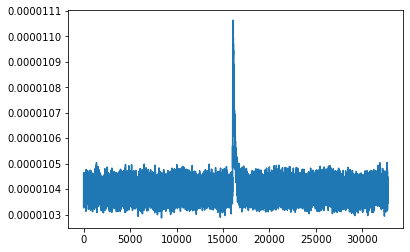

In [33]:
plt.plot(data['23231219_184002']['PBS1'][0])

In [40]:
raw_data['23231219_184002']['PBS1'][idx]['event']['EventNumber']

152887

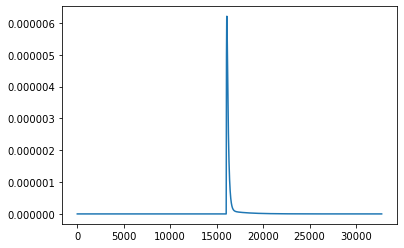

In [82]:
plt.plot(template_ss['23231219_184002']['PT'][2])


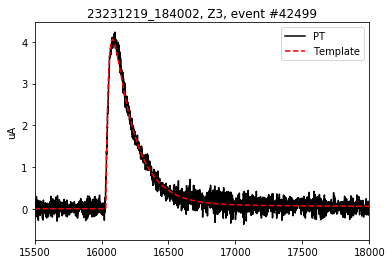

In [119]:
idx = 0
key = series[0]
high_cutoff, fs, order = 1000, 625000, 10
plt.figure()
c = 'PT'
bs_corrected = traces_ped_sub[key][c][idx]
lp_filtered = (bs_corrected)
temp = template_ss[key][c][idx]
plt.plot((lp_filtered)*1e6,label=c,color='black',linestyle='-')
plt.plot((temp)*1e6,color='red',linestyle='--',label='Template')
plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))

plt.legend()
plt.xlim(15500,18000)
#plt.xlim(15000,18000)
plt.ylabel('uA')
#plt.ylim(-0.02,0.14)
plt.show()

In [126]:
'''
    Save tra
'''
key = series[0]
save=True
for idx in range(len(event_numbers)):
    for c in channels:
        if(det=='Z3' and c == 'PAS1'):
            continue
        #plt.ioff()
        plt.figure()
        
        bs_corrected = traces_ped_sub[key][c][idx]
        lp_filtered = (bs_corrected)
        temp = template_ss[key][c][idx]
        plt.plot((lp_filtered)*1e6,label=c,color='black',linestyle='-')
        plt.plot((temp)*1e6,color='red',linestyle='--',label='Template')
        plt.title(key+', '+det+', event #%d'%(raw_data[key]['PFS1'][idx]['event']['EventNumber']))

        plt.legend()
        plt.xlim(15500,18000)
        plt.ylabel('uA')
        #plt.show()
        savename = './plots/traces/%s/Event%d/%s.png'%(det,idx,c)
        if(save):
            plt.savefig(savename)
            print(savename)
        plt.close()
        


./plots/traces/Z1/Event0/PT.png
./plots/traces/Z1/Event0/PAS1.png
./plots/traces/Z1/Event0/PBS1.png
./plots/traces/Z1/Event0/PCS1.png
./plots/traces/Z1/Event0/PDS1.png
./plots/traces/Z1/Event0/PES1.png
./plots/traces/Z1/Event0/PFS1.png
./plots/traces/Z1/Event0/PAS2.png
./plots/traces/Z1/Event0/PBS2.png
./plots/traces/Z1/Event0/PCS2.png
./plots/traces/Z1/Event0/PDS2.png
./plots/traces/Z1/Event0/PES2.png
./plots/traces/Z1/Event0/PFS2.png
./plots/traces/Z1/Event1/PT.png
./plots/traces/Z1/Event1/PAS1.png
./plots/traces/Z1/Event1/PBS1.png
./plots/traces/Z1/Event1/PCS1.png
./plots/traces/Z1/Event1/PDS1.png
./plots/traces/Z1/Event1/PES1.png
./plots/traces/Z1/Event1/PFS1.png
./plots/traces/Z1/Event1/PAS2.png
./plots/traces/Z1/Event1/PBS2.png
./plots/traces/Z1/Event1/PCS2.png
./plots/traces/Z1/Event1/PDS2.png
./plots/traces/Z1/Event1/PES2.png
./plots/traces/Z1/Event1/PFS2.png
./plots/traces/Z1/Event2/PT.png
./plots/traces/Z1/Event2/PAS1.png
./plots/traces/Z1/Event2/PBS1.png
./plots/traces/Z1/Ev